Notebook for various spectra visualization methods
Will work against persisted data here, but methods should work in other contexts

In [21]:
#imports and env
import numpy as np
import pickle
from matplotlib import pyplot as plt
from pathlib import Path
#update path to use our packages
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker2 import spectrum_maker
#define absolute path to repo top level and then relative vs. that
top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

In [22]:
#working with spec_maker2 here which combines lines then provides composite
#should recover the same Li2CO3 spectrum here as we get from the NIST LIBS website
fracs_dict = {'Li':0.33, 'C':0.17, 'O':0.5}
my_maker = spectrum_maker()
wave, spec, lines_dict = my_maker.make_spectra(fracs_dict)

In [23]:
#import the expermental libs spectra from LBNL
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
libs_spec.shape

(23431, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

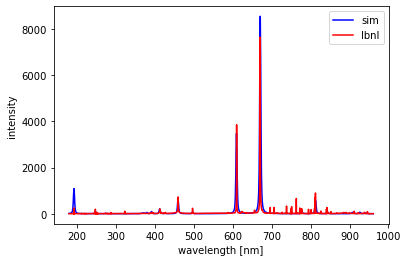

In [24]:
plt.plot(wave, spec, color='blue', label = 'sim') 
plt.plot(libs_spec[:,0],libs_spec[:,1], color='red', label='lbnl')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

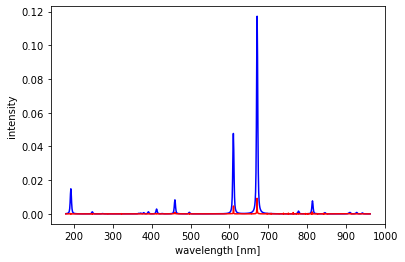

In [8]:
#Scale to same total intensity and plot again
scale_spec = spec / np.sum(spec)
lab_spec = libs_spec[:,1] / np.sum(libs_spec[:,1])
plt.plot(wave, scale_spec, color='blue') 
plt.plot(libs_spec[:,0],lab_spec, color='red')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [9]:
#opposite of expected! experimental must have many small non-zero values
print(np.sum(lab_spec))
print(np.sum(scale_spec))

0.9999999999999998
0.9999999999999997


In [10]:
#location of max Li peak on simulated
wave[np.argmax(lines_dict['Li'])] #671 nm
lines_dict['Li'][np.argmax(lines_dict['Li'])] #41005.8, line height > voigt max?
np.argmax(spec) + 180 #671
sim_scale = 10000 / np.max(spec)
sim_scale #0.5841232544953427

1.1682465089906855

In [11]:
#scaling factor for LBNL libs gun
libs_spec[:,0][np.argmax(libs_spec[:,1])] #670.7333333333884
lab_scaling =  10000 / np.max(libs_spec[:,1])
lab_scaling #1.305852886549987

1.305852886549987

In [12]:
#confirm other elements don't contribute at 671
lines_dict['C'][671 - 180] #0
lines_dict['O'][671 - 180] #0

0.0

<function matplotlib.pyplot.show(close=None, block=None)>

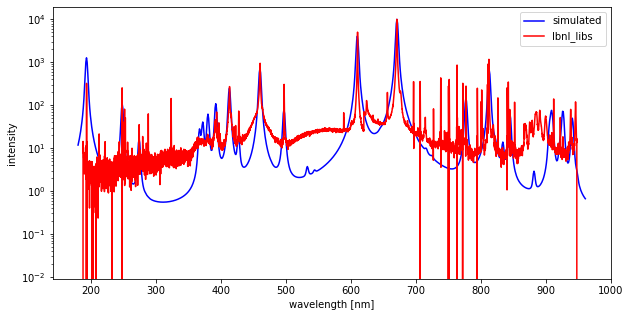

In [13]:
#Look at an apples to apples scaling
lab_scaled = lab_scaling * libs_spec[:,1]
sim_scaled = sim_scale * spec

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, sim_scaled, color='blue', label='simulated') 
plt.plot(libs_spec[:,0],lab_scaled, color='red', label='lbnl_libs')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.yscale('log')
plt.legend()
plt.show

In [14]:
#Read in the nist libs data for Li2CO3 for comparison too
nist_libs = np.genfromtxt(datapath / "nist_libs/Li2CO3_nist_libs.csv", delimiter=',', skip_header=1, filling_values=0)
nist_libs = nist_libs[:,0:2]
nist_libs.shape
#max peak
nist_libs[:,0][np.argmax(nist_libs[:,1])] #670.81
nist_scale =  10000 / np.max(nist_libs[:,1])
nist_scale #0.5274261603375527
#why different? more wl so check their max val
np.max(nist_libs[:,1]) #18960 perhaps different than our Voigt to make peaks?
nist_scaled = nist_libs[:,1] * nist_scale

<function matplotlib.pyplot.show(close=None, block=None)>

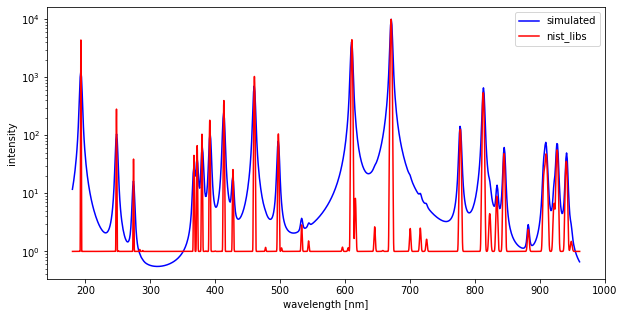

In [16]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, sim_scaled, color='blue', label='simulated') 
plt.plot(nist_libs[:,0],nist_scaled +1, color='red', label='nist_libs')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.yscale('log')
plt.legend()
plt.show

In [17]:
np.min(spec)

0.4712145274856605

In [18]:
#compare the sum of lines coming back to the nist lines for Li2CO3. Should be same
nist_lines = np.genfromtxt(datapath / "nist_libs/Li2CO3_nist_lines.csv", delimiter=',', skip_header=1, filling_values=0)

In [19]:
#aggregate all the intensities to a single sum for each wavelength
line_wl = np.round(nist_lines[:,0]).astype('int')
line_int = np.sum(nist_lines[:,1:], axis=1)
nist_int = np.zeros(len(wave))
for i in range(len(line_wl)):
    nist_int[line_wl[i]-180] += line_int[i]

In [20]:
np.max(lines_dict['comp'] - nist_int) #2.610000002601737 very close!

2.610000002601737

In [26]:
fracs_dict = {'Sn':0.9, 'Pr':0.1}
wave, spec, lines_dict = my_maker.make_spectra(fracs_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

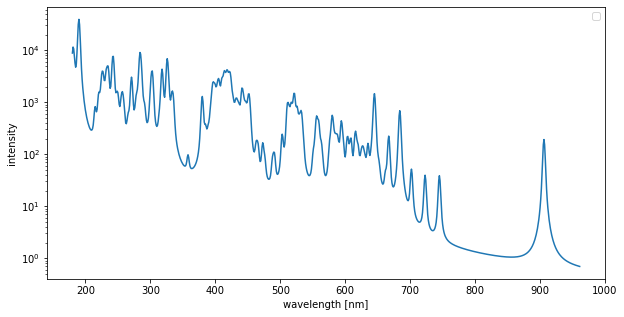

In [27]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, spec) 
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.yscale('log')
plt.legend()
plt.show